# Анализ данных о пользователях с подпиской и без

Мы имеем данные о поездках пользователей с подпиской и без. Наша задача проанализировать данные и проверить гипотезы, которые помогут принять решения для развития бизнеса.

Мы предобработаем данные: избавимся от пропусков, дубликатов и выбросов, если они есть. Исследуем данные о пользователях, проверим гипотезы о пользователях с подпиской и сформулируем ввод о действиях для роста бизнеса.

У нас данные о пользователях приложения аренды самокатов.

Сервисом можно пользоваться:
 - без подписки
   - абонентская плата отсутствует;
   - стоимость одной минуты поездки 8 рублей;
   - стоимость старта (начала поездки) 50 рублей;
 - с подпиской Ultra
   - абонентская плата 199 рублей в месяц;
   - стоимость одной минуты поездки 6 рублей;
   - стоимость старта — бесплатно.

In [3]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom, norm
from math import sqrt

## Загрузка данных

In [5]:
users = pd.read_csv('/users_go.csv')
rides = pd.read_csv('/rides_go.csv')
subscriptions = pd.read_csv('/subscriptions_go.csv')
display(users.head())
display(rides.head())
display(subscriptions)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Описание данных**

У нас три таблицы с данными о пользователях, их поездках и подписках.

**Пользователи — users_go.csv**
- user_id	- уникальный идентификатор пользователя
- name	- имя пользователя
- age	- возраст
- city	- город
- subscription_type	- тип подписки (free, ultra)

**Поездки — rides_go.csv**
- user_id	- уникальный идентификатор пользователя
- distance	- расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration	- продолжительность сессии (в минутах)
- date	- дата поездки

**Подписки — subscriptions_go.csv**
- subscription_type -	тип подписки
- minute_price	- стоимость одной минуты поездки
- start_ride_price	- стоимость начала поездки
- subscription_fee	- стоимость ежемесячного платежа

In [7]:
display(users.info());
display(rides.info());
display(subscriptions.info());

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


None

Представлены данные о 1565 пользователях и 18068 поездках. В таблице *subscriptions* описаны 2 типа подписок. Пропущенных значений нет. Дата в таблице *rides* представлены типом *object*, это нужно исправить.

## Предобработка данных

In [10]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d') #изменим тип стобца с датой на datetime
rides['month'] = rides['date'].dt.month #создаем столбец с месяцем поездки
display(rides['date'].min(), rides['date'].max()) #первая и последняя даты

Timestamp('2021-01-01 00:00:00')

Timestamp('2021-12-30 00:00:00')

Данные представлены в период с 1 января 2021 по 30 декабря 2021.

In [12]:
#проверяем наличие явных дубликатов
display(users.duplicated().sum())
display(rides.duplicated().sum())

31

0

31 повтор в таблице с пользователями. Удалим их.

In [14]:
users.drop_duplicates(inplace=True, ignore_index=True)

На данном этапе мы предобработали данные: преобразовали тип даты в таблице *rides*, добавили столбец с номером месяца, проверили период предоставленных наблюдений и удалили явные дубликаты в таблице *users*. Иных дубликатов и пропусков нет.

## Исследовательский анализ данных

### Частота встречаемости городов

,city,user_id
0,Москва,168
1,Тюмень,180
2,Омск,183
3,Сочи,189
4,Краснодар,193
5,Ростов-на-Дону,198
6,Екатеринбург,204
7,Пятигорск,219


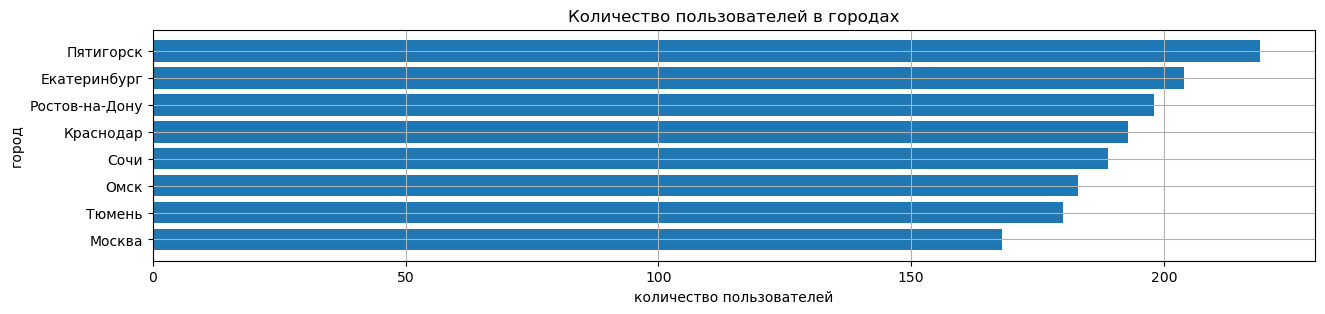

In [18]:
cities = users.pivot_table(index='city', values='user_id', aggfunc='count')
cities = cities.sort_values(by='user_id').reset_index(drop=False)
display(cities)
fig, ax = plt.subplots(figsize=(15,3))
plt.grid(True)
ax.set_title('Количество пользователей в городах')
plt.xlabel("количество пользователей")
plt.ylabel("город")
plt.barh(cities['city'], cities['user_id'])
plt.show()

На сервисе зарегистрированы пользователи из 8 городов. Наибольшее количество в Пятигорске (219), наименьшее в Москве (168).

###  Соотношение пользователей с подпиской и без подписки

,user_id
subscription_type,
free,835
ultra,699


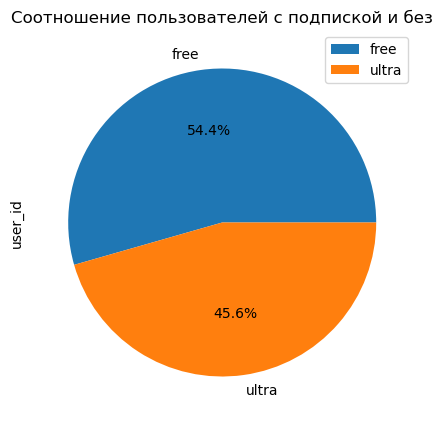

In [21]:
subscriptions_count = users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
display(subscriptions_count)
subscriptions_count.plot.pie(y='user_id', autopct='%1.1f%%', 
                             title='Соотношение пользователей с подпиской и без', figsize=(5,5));

Пользователей с подпиской Ultra меньше, чем пользователей без подписки. Но разница между ними незначительная.

### Возраст пользователей

count    29.000000
mean     26.103448
std       8.706914
min      12.000000
25%      19.000000
50%      26.000000
75%      33.000000
max      43.000000
Name: age, dtype: float64

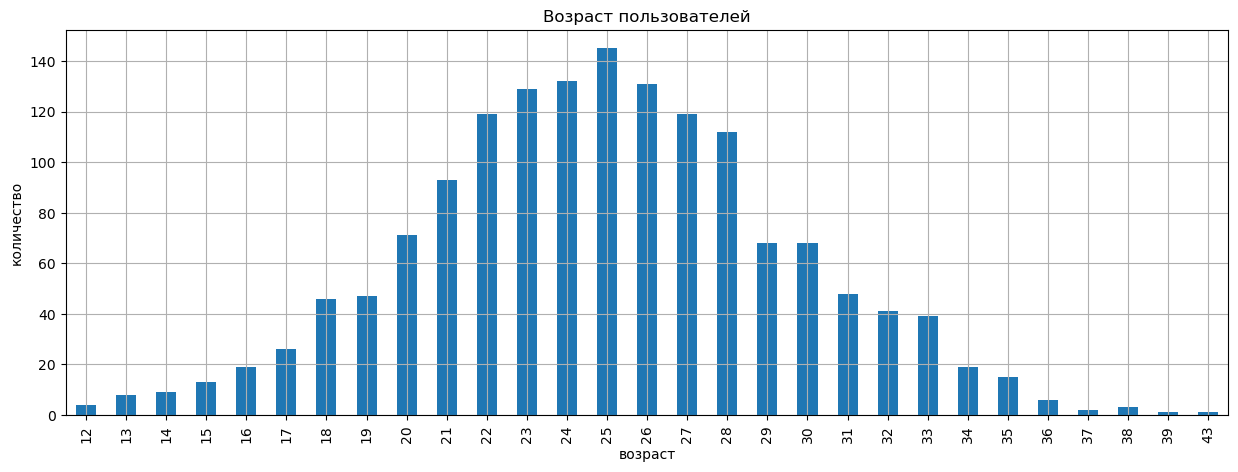

In [24]:
users_age = users.pivot_table(index='age', values='user_id', aggfunc='count')
users_age = users_age.reset_index(drop=False)
display(users_age['age'].describe())
users_age.plot(x='age', y='user_id', kind='bar', legend=False, grid=True,
               figsize=(15,5), xlabel='возраст', ylabel='количество',
               title='Возраст пользователей');

На сервисе зарегистрированы пользователи от 12 до 43 лет. Большая часть пользователей от 20 до 30 лет. 26 лет - среднее значение возраста. Распределение близко к нормальному.

### Расстояние, которое пользователь преодолел за одну поездку

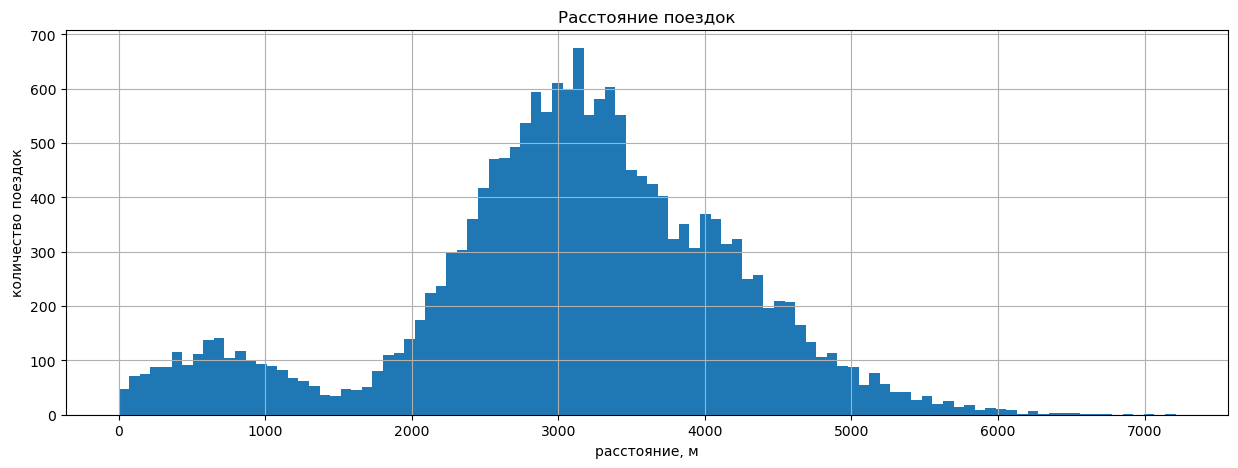

In [27]:
plt.title('Расстояние поездок')
plt.xlabel("расстояние, м")
plt.ylabel("количество поездок")
rides['distance'].hist(bins=100, figsize=(15,5)); #гистограмма расстояний

In [28]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Видим, что есть аномально короткие поездки. Поездки с дистанцией в пару метров могли быть из-за неполадок с самокатом, которые пользователи заметили после начала аренды.

Максимальная длина поездки 7211 метров.

Медина 3133 метра.

Распределение разделилось на два "около нормальных". Первое от 0 до 1500м и пиком около 750м. Максимум ворого около 3200м.

### Продолжительность поездок

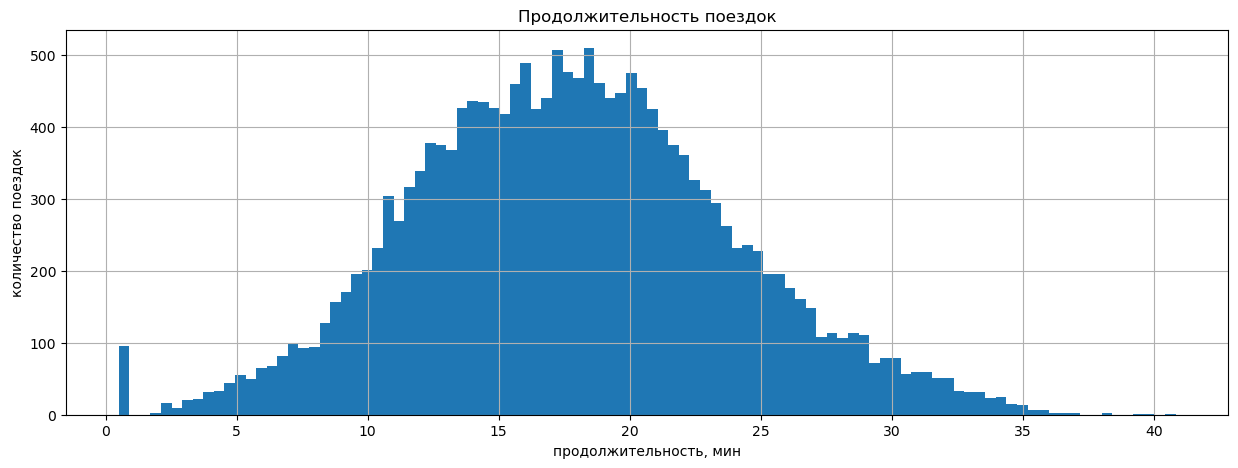

In [31]:
plt.title('Продолжительность поездок')
plt.xlabel("продолжительность, мин")
plt.ylabel("количество поездок")
rides['duration'].hist(bins=100, figsize=(15,5)); #гистограмма продолжительности

In [32]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [33]:
rides.query('duration == 0.5').count()

user_id     95
distance    95
duration    95
date        95
month       95
dtype: int64

In [34]:
rides.query('duration == 0.5')['distance'].min()

4030.308008428866

Рапределение близко к нормальному.

Средняя продолжительность поездок 17 минут, максимальная 40.

Есть выброс в значении 30 секунд. 95 поездок с такой продолжительностью. При этом дистанция поездок более 4 км. Похоже на какой-то сбой в приложении.

## Объединение данных

In [37]:
data = users.merge(rides).merge(subscriptions) #объединим таблицы
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


Объединение прошло успешно. Количество записей совпадает с количеством поездок, пропусков и лишних строк нет.

In [40]:
#создаем две таблицы. С подпиской и без подписки
users_with_subscriptions = data.query('subscription_type == "ultra"')
users_without_subscriptions = data.query('subscription_type != "ultra"')
display(users_with_subscriptions.head())
display(users_without_subscriptions.head())
if users_with_subscriptions.shape[0]+users_without_subscriptions.shape[0] == data.shape[0]:
    print('Суммарное количество данных в таблицах совпадает с исходным')

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


Суммарное количество данных в таблицах совпадает с исходным


count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

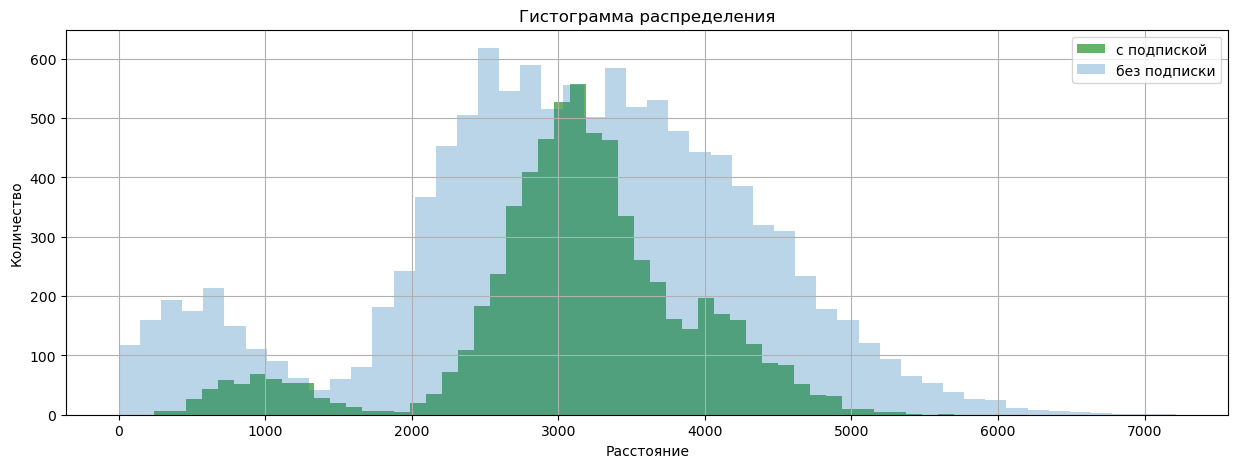

In [41]:
#сравним расстояния аренды
display(users_with_subscriptions['distance'].describe()) #с подпиской
display(users_without_subscriptions['distance'].describe()) #без подписки
fig, ax = plt.subplots(figsize=(15,5))
users_with_subscriptions['distance'].hist(ax=ax, bins=50, alpha=0.6, color ='green')
users_without_subscriptions['distance'].hist(ax=ax, bins=50, alpha=0.3)
lgnd = ax.legend(['с подпиской', 'без подписки'], loc='upper right')
ax.set_title('Гистограмма распределения');
ax.set_xlabel('Расстояние');
ax.set_ylabel('Количество');
plt.show()

Поездок без подписки больше.

Маленькие расстояния проезжают пользователи без подписки. Некоторые знакомятся с сервисом, пробуют.

У обеих групп виден минимум. С подпиской мало поездок с расстоянием 2000м, без подписки 1400м. Среднее расстояние у обеих групп ~ 3100м.

Наличие минимума сложно объяснить. Есть много факторов, которые могли повлиять (какие данные попали в выборку, в каких городах совершались поездки и другие).

У пользователей без подписки больший диапазон расстояния поездок и имеются аномально короткие поездки.

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

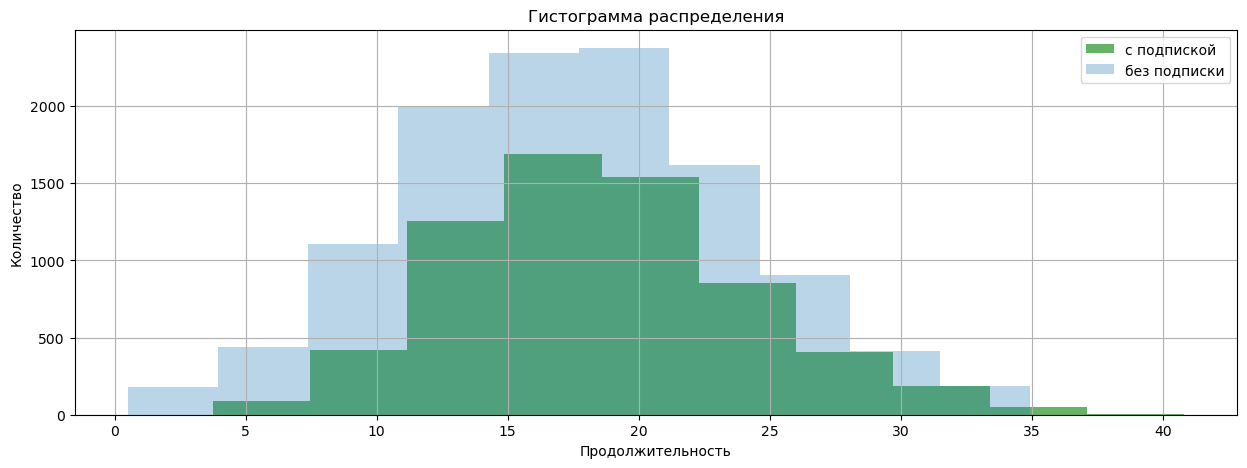

In [43]:
#сравним продолжительность аренды
display(users_with_subscriptions['duration'].describe()) #с подпиской
display(users_without_subscriptions['duration'].describe()) #без подписки
fig, ax = plt.subplots(figsize=(15,5))
users_with_subscriptions['duration'].hist(ax=ax, alpha=0.6, color ='green')
users_without_subscriptions['duration'].hist(ax=ax, alpha=0.3)
lgnd = ax.legend(['с подпиской', 'без подписки'], loc='upper right')
ax.set_title('Гистограмма распределения');
ax.set_xlabel('Продолжительность');
ax.set_ylabel('Количество');
plt.show()

Видно, что очень короткие поездки совершали пользователи без подписки. Может, тестировали приложение. Долгие поездки у пользователей с подпиской. Средняя продолжительность в обеих группах ~ 18 минут.

У пользователей с подпиской диапазон значение чуть больше, но не значительно.

Выяснилось, что аномально короткие поездки в 30 секунд у пользователей без подписки. Можно предположить, что у них был промокод на пробную поездку.

## Подсчёт выручки

In [46]:
data['duration'] = np.ceil(data['duration']) #округлим значение продолжительности поездки
data_revenue = data.pivot_table(index=['user_id', 'minute_price', 'start_ride_price', 'subscription_fee', 'month'], 
                                values=['distance', 'duration'], aggfunc=['sum', 'count'])
data_revenue.columns = ['total_distance', 'total_time', 'count', 'delete']
data_revenue = data_revenue.reset_index(drop=False)
data_revenue['revenue'] = (data_revenue['start_ride_price']*data_revenue['count']+
                           data_revenue['minute_price']*data_revenue['total_time']+
                           data_revenue['subscription_fee'])
data_revenue.drop(['minute_price', 'start_ride_price', 'delete'], axis=1, inplace=True);

In [47]:
data_revenue.head() #таблица с выручкой

,user_id,subscription_fee,month,total_distance,total_time,count,revenue
0,1,199,1,7027.511294,42.0,2,451.0
1,1,199,4,754.159807,7.0,1,241.0
2,1,199,8,6723.470560,46.0,2,475.0
3,1,199,10,5809.911100,32.0,2,391.0
4,1,199,11,7003.499363,56.0,3,535.0


Создали таблицу с выручкой по каждому пользователю за каждый месяц.

## Проверка гипотез

### Пользовалели с подпиской тратят больше времени на поездки, чем пользователи без подписки

H0: Средние продолжительности поездок у пользователей с подпиской и без подписки равны.

H1: Средняя продолжительность поездок у пользователей с подпиской больше, чем у пользователей без подписки.

In [52]:
results = st.ttest_ind(users_with_subscriptions['duration'], 
                       users_without_subscriptions['duration'], 
                       alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Гипотеза, что средние продолжительности поездок у пользователй с подпиской и без нее равны, была отвергнута в пользу альтернативной, что продолжительности поездок у пользоватей с подпиской больше. Можно говорить, что пользователи с подпиской тратят больше времени на поездки.

### Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

Н0: Средние расстояние поездок у пользователей с подпиской равно 3130м.

Н1: Среднее расстояние поездок у пользователей с подпиской больше 3130м.

In [56]:
results = st.ttest_1samp(users_with_subscriptions['distance'], 3130, alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть гипотезу, что пользователи с подпиской проезжают в среднем 3130м, в пользу гипотезы, что пользователи в среднем проезжают больше 3130м. Можно говорить, что расстояние поездок пользователей с подпиской не превышает 3130м.

### Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Н0: Месячная выручка от пользователей с подпиской равна выручке от пользователей без подписки.

Н1: Месячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

In [60]:
revenue_users_with_subscriptions = data_revenue.query('subscription_fee == 199')
revenue_users_without_subscriptions = data_revenue.query('subscription_fee == 0')
results = st.ttest_ind(revenue_users_with_subscriptions['revenue'], 
                       revenue_users_without_subscriptions['revenue'], 
                       alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Гипотеза, что месячные выручки от пользователей с подпиской и без равны отвергается в пользу альтернативной, что выручка от пользователей с подпиской выше.

<div style="border:solid purple 1px; padding: 20px">
    
Мы проверили гипотезы о пользователях с подпиской. Выяснили, что продолжительность поездок дольше, чем у пользователей без подписки. Мы получаем месячную выручку от пользователей с подпиской выше, чем без. И узнали, что расстояние поездки не превышает оптимального с точки зрения износа самоката.
    
Можно сделать вывод, что увеличение количества пользователей с подпиской - хорошее решение для роста бизнеса.

### Количество обращений в поддержку после обновления сервера снизилось

Н0: Количества обращений в поддержку до и после обновления равны.

Н1: Количество обращений в поддержку после обновления уменьшилось.


Мы проверяем гипотезу о равенстве среднего значения генеральной совокупности до и после изменения. Для этого используем метод `scipy.stats.ttest_rel()`. Передаем выборки после и до изменения, указываем `alternative='less'`, чтобы проверить, что среднее генеральной совокупности после обновления меньше среднего значения до изменения.

## Распределения

### Количество промокодов, которое нужно разослать, чтобы получить минимум 100 продлений подписки

Нам нужно выяснить, какое минимальное количество промокодов на месяц бесплатной подписки нужно разослать, чтобы получить минимум 100 продлений, при условии, что после пробного периода подписку продлевают 10% пользователей. Вероятность не выполнить план должна быть ~5%.

In [68]:
p=0.1 #вероятность продления подписки
#предположим, что минимальное число промокодов находится в интервале от 1000 до 2000
#вычислим количество промокодов, при котором вероятность получить меньше 100 продлений меньше 5%
for n in range(1000,2000):
    if st.norm(n*p, sqrt(n * p * (1 - p))).cdf(100)<0.05:
        break
    else:
        continue
n #минимальное количество промокодов, которое нужно разослать, чтобы получить 100 подписок с вероятностью 95%

1169

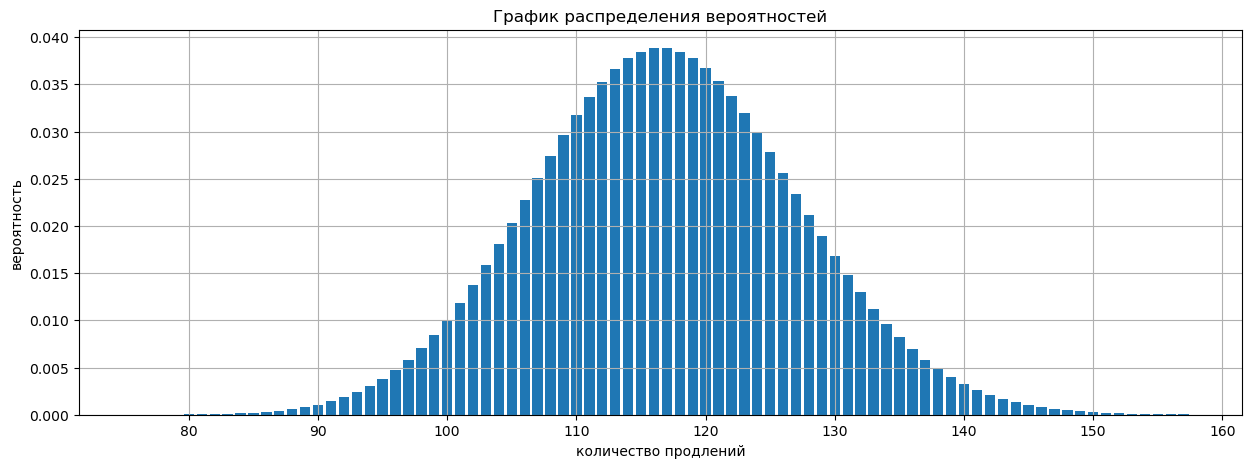

In [69]:
#задаем границы графика
left=round(n * p - 4 * sqrt(n * p * (1 - p)))
right=round(n * p + 4 * sqrt(n * p * (1 - p)))
distr=[]
for k in range(0, n+1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
fig, ax = plt.subplots(figsize=(15,5))
plt.grid(True)
ax.set_title('График распределения вероятностей')
plt.xlabel("количество продлений")
plt.ylabel("вероятность")
plt.bar(range(left,right), distr[left:right]); #график распределения вероятностей

In [70]:
sum(distr[0:100]) #вероятность получить менее 100 подписок

0.042448296153510624

Чтобы выполнить поставленную задачу, нужно отправить 1169 промокодов.

### Вероятность, что уведомление откроют не более 399,5 тыс. пользователей.

Планируется разослать 1 млн уведомлений. Известно, что уведомления открывают около 40% пользователей. Нужно оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

У нас биномиальное распределение с большим n=1000000 и p=0,4 (близким к 0,5), можем аппроксимировать распределение к нормальному.

In [75]:
n=1000000
p=0.4
mu = n * p
sigma = sqrt(n * p * (1 - p))
st.norm(mu, sigma).cdf(399500)
#аппроксимируем распределение нормальным и считаем вероятность, что уведомление откроют менее 399500 пользователей

0.15371708296369768

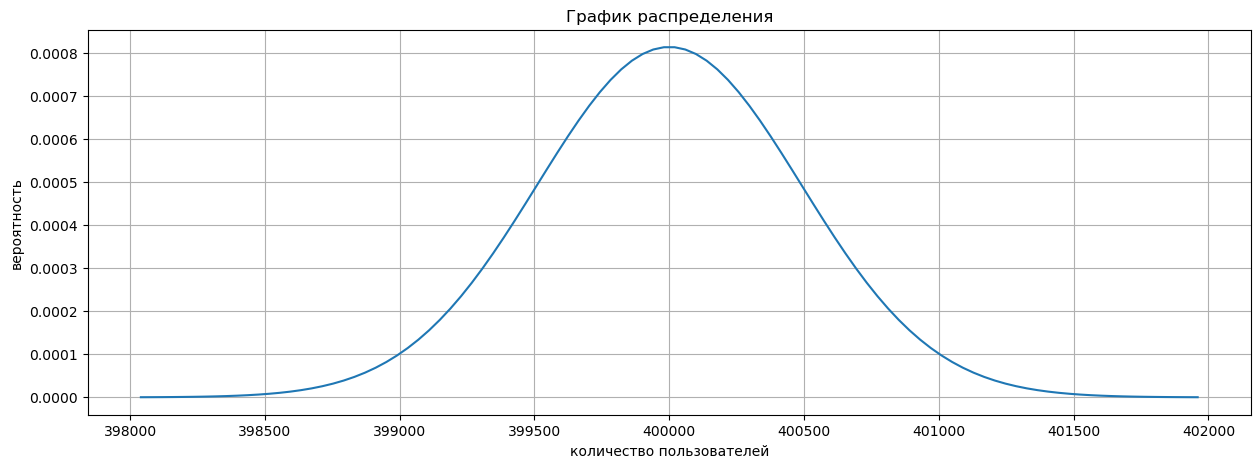

In [76]:
def linspace(start, stop):
    step = (stop - start) / 99
    result = []
    for i in range(100):
        result.append(start + step * i)
    return result

# границы промежутка, в котором будем строить аппроксимацию 
left = round(mu - 4 * sigma)
right = round(mu + 4 * sigma)
x = linspace(left, right) # получаем список из 100 чисел от left до right
fig, ax = plt.subplots(figsize=(15,5)) # рисуем график нормального распределения
ax.plot(x, norm.pdf(x, mu, sigma))
plt.grid(True)
ax.set_title('График распределения')
plt.xlabel("количество пользователей")
plt.ylabel("вероятность")
plt.show();

Вероятность того, что уведомление откроют менее 399,5 тыс. пользователей, 15%.

## Вывод

Мы проанализировали информацию о пользователях сервиса и их поездках.

Сначала подготовили данные к анализу: избавились от явных дубликатов и преобразовали типы данных.

Потом проанализировали данные:
- Узнали, что в приложении зарегистрированы пользователи от 12 до 43 лет. 26 - средний возраст, основная возрастная группа от 20 до 30 лет. 
- Представлены 8 городов, в среднем по 190 пользователей в каждом. Наименьшая группа в Москве, наибольшая в Пятигорске.
- Пользователей без подписки незначительно больше.
- Выяснили, что среднее расстояние 3100м, максимальное 7200м. На гистограмме растояний два пика в 750м и в 3100м. И есть аномально коротние поездки.
- Заметили, что есть 95 поездок с большим расстоянием и продолжительностью 30 секунд.
- Средняя продолжительность поездок 17 минут, максимальная 40 минут.

Далее сравнили поездки пользователей с подпиской и без по расстоянию и продолжительности. Поездок без подписки больше. Среди них много коротких. Еще зафиксировали подозрительный минимум в расстоянии (около 1500м), можно разобраться, откуда он берется.

Мы узнали, что у пользователей без подписки больше диапозон расстояния поездок и есть аномально короткие. У пользователей с подпиской немного больше диапозон продолжительности и максимальная продолжительность дольше. Среднее время и расстояние схожи у обеих групп.

Для продакт-менеджеров проверили несколько гипотез о пользователях с подпиской. Мы узнали, что пользователи с подпиской не проезжают расстояние большее, чем оптимальное с точки зрения износа самоката, тратят на поездки больше времени, чем пользователи без подписки, и приносят большую месячную прибль.

Для отдела маркетинга посчитали, какое минимальное количество промокодов на бесплатный месяц подписки нужно отправить, чтобы получить минимум 100 новых подписчиков.

На основе анализа и проверки гипотез можно сделать вывод, что увеличение количества подписчиков благоприятно отразится на росте бизнеса.
